# Convolutional Neural Network w/ Tensorflow 

**Image Classification Example**

**Dataset:** 

- CIFAR10 
- https://github.com/udacity/deep-learning/blob/master/image-classification/dlnd_image_classification.ipynb

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
import tqdm
import pickle

____
### Load Images

In [202]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

def normalize(x):
    
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return feats / 255
    

def one_hot_encode(x):
    
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """

    encoded = OneHotEncoder(sparse=False)
    to_encode = np.array(x).reshape(len(x),1)
    
    return encoded.fit_transform(to_encode)


def get_sample_data(cifar10_dataset_folder_path, batch_id, sample_id):
    
    """
    Display Stats of the the dataset
    """
    
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Labels Breakdown: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.axis('off')
    plt.imshow(sample_image,aspect='auto')

    return features,labels


Stats of batch 1:
Samples: 10000
Labels Breakdown: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}

Example of Image 1:
Image - Min Value: 5 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


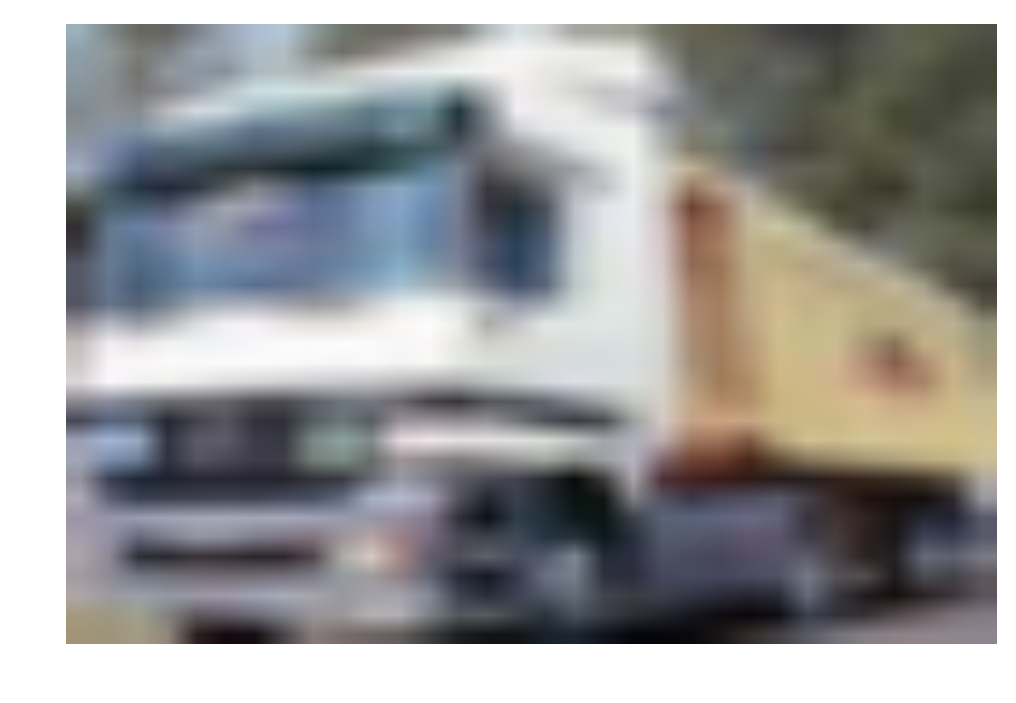

In [203]:
if __name__ == '__main__':
    
    cifar10_dataset_folder_path = 'data/cifar-10-batches-py'
    feats,labels = get_sample_data(cifar10_dataset_folder_path,batch_id=1,sample_id=1)

    # Normalize Images
    feats = normalize(feats)

    # One Hot Encode
    labels = one_hot_encode(labels)

### Preprocess Data and Pickle 

In [210]:
def preprocess_and_save_data(cifar10_dataset_folder_path,n_batches=5,validation_size=0.10):
    
    """
    Preprocess Training and Validation Data
    """
    
    X_validation = []
    y_validation = []

    for batch_i in tqdm.tqdm(range(1, n_batches + 1),desc='Preprocessing Batches'):

        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        X_train = normalize(features)
        y_train = one_hot_encode(labels)
        
        # 10% Validation Set
        validation_set = int(len(X_train) * validation_size)

        # Preprocess and save a batch of training data
        file_name = 'data/pickle/preprocess_batch_' + str(batch_i) + '.p'
        
        #Pickel Training 
        pickle.dump((X_train[:-validation_set], y_train[:-validation_set]), open(file_name, 'wb'))

        # Use a portion of training batch for validation
        X_validation.extend(X_train[-validation_set:])
        y_validation.extend(y_train[-validation_set:])
    
    # Pickle Validation Set
    pickle.dump((np.array(X_validation),np.array(y_validation)), open('data/pickle/preprocess_validation.p', 'wb'))

    # Get Testing Set
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # Load Testing Data Set
    X_test = normalize(batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1))
    y_test = one_hot_encode(batch['labels'])

    # Pickle Testing Set
    pickle.dump((X_test,y_train), open('data/pickle/preprocess_test.p', 'wb'))
    
    # Summary Statistics
    print('='*10 + 'Summary' + '='*10)
    print('X Train Shape:', X_train.shape)
    print('Y Train Shape:', y_train.shape)
    
    print('X Validation Shape:', np.array(X_validation).shape)
    print('Y Validation Shape:', np.array(y_validation).shape)
    
    print('X Test Shape:', X_test.shape)
    print('Y Test Shape:', y_test.shape)
    
    print('Complete!')
    
if __name__ == '__main__':
    
    %time preprocess_and_save_data(cifar10_dataset_folder_path)

Preprocessing Batches: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


==========Summary==========
X Train Shape: (10000, 32, 32, 3)
Y Train Shape: (10000, 10)
X Validation Shape: (5000, 32, 32, 3)
Y Validation Shape: (5000, 10)
X Test Shape: (10000, 32, 32, 3)
Y Test Shape: (10000, 10)
Complete!
CPU times: user 2.69 s, sys: 2.31 s, total: 5.01 s
Wall time: 5.75 s


____
### Convolutional Neural Network

In [260]:
class Convolutional_Nerual_Network():
    
    """ Train ConvNet """
    
    def __init__(self,params,is_training):
        
        # Store Accuracies
        self.training_accuracies = []
        self.val_accuracies = []
        
        # Toggle between training
        self.training = is_training
        if is_training:
            self.probability = 0.50
        else:
            self.probability = 1.0
            
        # Initialize Build
        self.build_network(**params)
        
        # Save model (path)
        self.save_model_path = 'models/image_classification'
        
    
    def load_preprocess_training_batch(self, batch_id, batch_size):
    
        """
        Load the Preprocessed Training data and return them in batches of <batch_size> or less
        """
        
        filename = 'data/pickle/preprocess_batch_' + str(batch_id) + '.p'
        features, labels = pickle.load(open(filename, mode='rb'))

        # Return the training data in batches of size <batch_size> or less
        return self.batch_features_labels(features, labels, batch_size)
    
    
    def batch_features_labels(self, features, labels, batch_size):
        
        """
        Split features and labels into batches
        """
        for start in range(0, len(features), batch_size):
            end = min(start + batch_size, len(features))
            yield features[start:end], labels[start:end]
           
        
    def get_validation_set(self):
        
        """
        Load Validation Pickled Object
        """
        
        filename = 'data/pickle/preprocess_validation' + '.p'
        X_val, y_val = pickle.load(open(filename,mode='rb'))
        
        return X_val,y_val
    
    
    def print_stats(self, session, feature_batch, label_batch, cost, accuracy):
        """
        Print information about loss and validation accuracy
        : session: Current TensorFlow session
        : feature_batch: Batch of Numpy image data
        : label_batch: Batch of Numpy label data
        : cost: TensorFlow cost function
        : accuracy: TensorFlow accuracy function
        """
        
        loss = session.run(cost, feed_dict={self.input: feature_batch, self.y: label_batch,\
                                            self.keep_prob: self.probability})

        acc = session.run(accuracy, feed_dict={self.input: feature_batch, self.y: label_batch,\
                                                 self.keep_prob: self.probability})

        print('Loss: {:.4f}  Validation Accuracy: {:.2f}%'.format(loss, acc*100))
    

    def conv2d_maxpool(self,x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
        """
        Apply convolution then max pooling to x_tensor
        :param x_tensor: TensorFlow Tensor
        :param conv_num_outputs: Number of outputs for the convolutional layer
        :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
        :param conv_strides: Stride 2-D Tuple for convolution
        :param pool_ksize: kernal size 2-D Tuple for pool
        :param pool_strides: Stride 2-D Tuple for pool
        : return: A tensor that represents convolution and max pooling of x_tensor
        """

        # Convolution Filter
        conv = tf.layers.conv2d(x_tensor,conv_num_outputs,conv_ksize,conv_strides,padding='SAME',activation=tf.nn.relu) 
        
        # Max Pooling
        max_pool = tf.layers.max_pooling2d(conv,pool_ksize,pool_strides,padding='SAME')
        
        return max_pool
    
    
    def flatten(self,x_tensor):
        """
        Flatten x_tensor to (batch size, flattened image size)
        : x_tensor: A tensor with size of output dimensions of last convolutional layer
        : return: A tensor of size (Batch Size, flattened image size).
        """

        return tf.contrib.layers.flatten(x_tensor)
    
    
    def fully_conn(self, x_tensor, num_outputs,activation=tf.nn.relu):
        
        """
        Apply a fully connected layer to x_tensor
        : x_tensor: A 2-D tensor where the first dimension is batch size
        : num_outputs: the number of output that the new tensor should be
        : return: A 2-D tensor where the second dimension is num_outputs
        """

        return tf.contrib.layers.fully_connected(x_tensor, num_outputs, activation_fn=activation)

 
    def build_network(self,**params):
        
        """
        Build Convnet Architecture
        :param params: input parameters dictionary
        : return: A tensor that represents the output layer
        """
        
        # Dropout Placeholder 
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')

        # Input Tensor
        self.input = tf.placeholder(tf.float32, shape=[None,params['height'],params['width'],params['n_channels']],name='x')
        
        # 1st Convolutional Layer
        conv2d_maxpool_layer_1 = self.conv2d_maxpool(self.input,params['conv_num_outputs_1'], 
                                 params['conv_ksize_1'],params['conv_strides_1'],
                                 params['pool_ksize_1'], params['pool_strides_1'])

        # Flatten Input Convolution Layer
        flatten = tf.nn.dropout(self.flatten(conv2d_maxpool_layer_1),self.keep_prob)

        # Fully Connected
        fully_connected_layer_1 = tf.nn.dropout(self.fully_conn(flatten, params['output_dim']*2),self.keep_prob)
        
        # Output Layer
        self.output_layer = tf.contrib.layers.fully_connected(fully_connected_layer_1, params['output_dim'])

        
    def train(self,session,learning_rate,epochs,batch_size,output_dim):
        
        """
        Train ConvNet
        :param session: tensorflow graph session
        :param learning_rate: learning rate for optimization
        :param epochs: number of iterations
        :param batch_size: size of batch for optimization 
        :param output_dim: output dimensions of network (i.e. class labels)
        : return: A tensor that represents the output layer
        """
        
        # Target
        self.y = tf.placeholder(tf.float32,shape=[None,output_dim],name='y')
    
        # Log-Odds
        logits = tf.identity(self.output_layer,name='logits')
        
        # Loss Function
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.y))
            
        # Define operations for testing validation set
        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(self.y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

        # Gradient Descent
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

        # Train model for the specified number of epochs
        for epoch in tqdm.tqdm(range(epochs)):
            
            # Loop over all batches
            n_batches = 2
            for batch_i in range(1, n_batches + 1):
                
                # Iterate over each sample of batch_size: n
                for batch_x_train, batch_y_train in self.load_preprocess_training_batch(batch_i, batch_size):
                
                    # Compute Loss on Training Set
                    session.run(optimizer,feed_dict={self.input: batch_x_train, self.y: batch_y_train,self.keep_prob: self.probability})
                
            # Summary stats
            if epoch % 100 == 0 and epoch != 0:
                print(epoch)
                print(epoch % 100)
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i))
                self.print_stats(session, batch_x_train, batch_y_train, cost, accuracy)
        
        # Save final model
        saver = tf.train.Saver()
        saver.save(session, self.save_model_path)
        
    def validation(self,session,output_dim):
        
        """
        Train ConvNet
        :param session: tensorflow session
        :param output_dim: output dimensions of network 
        : return: Accuracy score for validation set
        """
        
        # Validation Features/Labels 
        X_val,y_val = self.get_validation_set()

        # Placeholder will store target labels for each mini batch
        labels = tf.placeholder(tf.float32, [None, output_dim],name='y_val')
        
        # Define operations for testing validation set
        correct_pred = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='val_accuracy')

        # Get Validation Score
        val_accuracy = session.run(accuracy,feed_dict={self.input: X_val, labels: y_val, self.keep_prob: self.probability})
        print('Validation Accuracy Score: {:.3f}%'.format(val_accuracy * 100))

### Train Model

In [261]:
def conv_layer_paramters(filt_size,layer):
    
    # Kernel size
    conv_ksize = filt_size
    
    # Kernel Stride
    conv_strides =(conv_ksize[0]/2, conv_ksize[1]/2)
    
    # Pool Size
    pool_ksize = (conv_ksize[0]/2, conv_ksize[1]/2)
    
    # Pool Strides
    pool_strides = (pool_ksize[0]/2, pool_ksize[1]/2)
    
    # Output Dimensions
    conv_num_outputs = conv_ksize[0] * conv_ksize[0]
    
    # Build Dictionary
    keys = ['{}_{}'.format(i,layer) for i in ['conv_ksize','conv_strides','pool_ksize',
                                              'pool_strides','conv_num_outputs']]
    vals = [conv_ksize,conv_strides,pool_ksize,pool_strides,conv_num_outputs]
    return dict(zip(keys,vals))
    
    
def get_nn_parameters():

    params = {

            'input_dim': 32*32, # input dimensions
            'height': 32, # image height
            'width': 32, # image width
            'output_dim': 10, # output class labels
            'n_channels': 3, # number of dimensions
            }
    
    # First Conv Layer Params
    params.update(conv_layer_paramters((8,8),1))
    
    return params


def train_and_test(learning_rate,epochs,batch_size,*args):
    
    # Input Parameters
    params = get_nn_parameters()

    # Reset default graph if training two different models
    tf.reset_default_graph()

    # Create instance of Neural Network for training and validation set
    convnet_train = Convolutional_Nerual_Network(params,True)
    convnet_val = Convolutional_Nerual_Network(params,False)
        
    # Train Model
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
    
        # Training and Validation Model
        convnet_train.train(sess,learning_rate,epochs,batch_size,params['output_dim'])
        convnet_val.validation(sess,params['output_dim'])

**For images, input tensor shape is as follows: [Batch Size, Height, Width, Channel]**

In [258]:
if __name__ == '__main__':
    
    # Tune Parameters
    learning_rate = 0.001
    epochs = 10
    batch_sample_size = 64

    %time model = train_and_test(learning_rate,epochs,batch_sample_size)

100%|██████████| 10/10 [00:35<00:00,  3.48s/it]


1.0
Validation Accuracy Score: 9.560%
CPU times: user 2min 21s, sys: 18.9 s, total: 2min 40s
Wall time: 37.2 s


### Test Model

In [259]:
def batch_features_labels(features, labels, batch_size):

    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]
            
            
def test_model(batch_size=64):
    """
    Test the saved model against the test dataset
    """
    
    save_model_path = 'models/image_classification'
    
    loaded_graph = tf.get_default_graph()
    X_test, y_test = pickle.load(open('data/pickle/preprocess_test.p', mode='rb'))

    with tf.Session() as sess:
        
        # Load Model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for X_test_batch, y_test_batch in batch_features_labels(X_test, y_test, batch_size):
            test_batch_acc_total += sess.run(loaded_acc,feed_dict={loaded_x: X_test_batch, 
                                                                   loaded_y: y_test_batch, 
                                                                   loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {0:.3f}\n'.format(test_batch_acc_total/test_batch_count))

test_model()

Testing Accuracy: 0.098

